$Author:$ Arne Fabritius
<br>
$Institution:$ Max Planck Institute for Neurobiology
<br>
$Group:$ Tools for Bioimaging, Oliver Griesbeck
<br>
$Revised:$ 2020-02-06
<br>
$Reference:$ 
<br>
Erdogan, M., Fabritius, A., Basquin, J. and Griesbeck, O.
<br>
Targeted In Situ Protein Diversification and Intra-Organelle Validation in Mammalian Cells,
<br>
Cell Chemical Biology, 2020
<br>
$Purpose:$ 
Analysis of next generation sequencing data for partially randomized 
<br>
single strand oligonucleotides, used as repair templates for a CRISPR/cas9
<br>
targeted repair of the fluorescent protein mRuby3 for the purpose of creating a diversified library.

### Data

Raw data was deposited into the Squence Read Archive (SRA) of the U.S. National Library of Medicine 
<br>
from the National Center for Biotechnoly Information (NCBI) 
<br>
Accession numbers:
<br>
SAMN14055904 - diversified oligonucleotides 


### Libraries to import

In [1]:
### basic 
import re
import numpy as np

### plotting
import matplotlib.pyplot as plt
import seaborn as sns

### handling of sequence data
from Bio.Seq import Seq                         
from Bio import SeqIO
from Bio.Alphabet import IUPAC     

%matplotlib inline

### Code

In [2]:
%%time
# This script takes single reads from Illumina MiSeq of a single strand oligonucleotide library in fastq format as input.
# The script filters all sequences acording to phred quality scores > 30 for each position and creates a new fasta file, 
# which is used in further analysis


### input section 

### input-file location and filename 
folder=""
filename = "LysoRyb-3_S1_L001_R1_001.fastq"
infile = folder+filename


### output-file location and filename
outfile= open(folder+re.split(".fastq",filename)[0]+"_Q30.fasta","w")

###############################################################################################################################

### initialize counters
count=0
count_Q30=0

### loop through input file and filter for Q>30 
with open(infile, "rU") as handle_file:
    for record in SeqIO.parse(handle_file, "fastq"):
        count+=1
        if min(record.letter_annotations["phred_quality"]) >= 30:
            outfile.write(">" + record.id + "\n")
            outfile.write(str(record.seq) + "\n")
            count_Q30+=1

            
### output 
outfile.close()        
print ("Total of %7d sequences processed" % (count))
print ("Total of %7d sequences with >Q30" % (count_Q30))
print ("Total of %4.1f %% sequences with >Q30" % (count_Q30/float(count)*100))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: 'U' mode is deprecated


Total of 3367059 sequences processed
Total of 1189905 sequences with >Q30
Total of 35.3 % sequences with >Q30
Wall time: 1min 16s


In [7]:
%%time
# This script processes a fasta file, which contains single reads filtered for a quality score of Q>30 for all bases.  

### input section 

### input-file location and filename 
folder=""
filename="LysoRyb-3_S1_L001_R1_001_Q30.fasta"

### sequences which identify region of interest 
ID_head = re.compile("CCCGTGATGCAGAAG")
ID_tail = re.compile("GGTGGTGGCCATCTG")

###############################################################################################################################

infile = folder+filename

### initialize counters
count=0
count_len_cor=0
### initialize dictionaries
length_dict ={}             ### length dictionary
DNA_dic ={}                 ### doctionary of unique DNA sequences of correct length

### loop through fasta file 
with open(infile, "rU") as handle_file:
    for record in SeqIO.parse(handle_file, "fasta"):
        DNA = str(record.seq)
        if ID_head.search(DNA) and ID_tail.search(DNA):
            count+=1
            DNA_1 = re.split(ID_head,DNA)[1]
            DNA_2 = re.split(ID_tail,DNA_1)[0]
            
            if len(DNA_2) not in length_dict:
                length_dict[len(DNA_2)] = 1
            elif len(DNA_2) in length_dict:
                length_dict[len(DNA_2)]+= 1
                
            if len(DNA_2) == 90:
                count_len_cor+=1
                if DNA_2 not in DNA_dic:
                    DNA_dic[DNA_2]=1
                elif DNA_2 in DNA_dic:
                    DNA_dic[DNA_2]+=1

                    
### output
print(" %d sequences have valid roi" % count)
print(" %d sequences have correct length" % count_len_cor)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 'U' mode is deprecated


 472295 sequences have valid roi
 402430 sequences have correct length
Wall time: 9.51 s


In [8]:
### library for protein sequences in full sequenced region

long_peptide_lib = {}

### loops through unique DNA dictionary, translates DNA
for dna in DNA_dic.keys():
    peptide = str(Seq(dna, IUPAC.unambiguous_dna).translate())
    
    ### creates a dicionary of unique protein sequences and counts them
    if peptide not in long_peptide_lib:
        long_peptide_lib[peptide] = DNA_dic[dna]
    elif peptide in long_peptide_lib:
        long_peptide_lib[peptide] += DNA_dic[dna]

### output
print(" %d unique variants on protein level" % len(long_peptide_lib))

 340219 unique variants on protein level


In [14]:
### library for DNA/protein sequences in modified region P146 N147 E149 T162 I164
oligo_lib={}       ### library for unique DNA sequences
peptide_lib = {}   ### library for unique protein sequences


### loops through unique DNA sequences with correct length, pics modified position and extracts DNA sequence of position
for dna in DNA_dic.keys():
    oligo = dna[18:24]+dna[27:30]+dna[66:69]+dna[72:75]
    if oligo not in oligo_lib:
        oligo_lib[oligo] = DNA_dic[dna]
    elif oligo in oligo_lib:
        oligo_lib[oligo] += DNA_dic[dna]

### loops through unique DNA sequences, translates DNA and adds unique protein sequences to dictionary        
for oligo in oligo_lib:
    peptide = str(Seq(oligo, IUPAC.unambiguous_dna).translate())
    
    if peptide not in peptide_lib:
        peptide_lib[peptide] = oligo_lib[oligo]
    elif peptide in peptide_lib:
        peptide_lib[peptide] += oligo_lib[oligo]        

### output

print(" %d unique variants in modified region on DNA level" % len(oligo_lib))
print(" %d unique variants in modified region on protein level" % len(peptide_lib))   

 401740 unique variants in modified region on DNA level
 337091 unique variants in modified region on protein level


### Figure 3

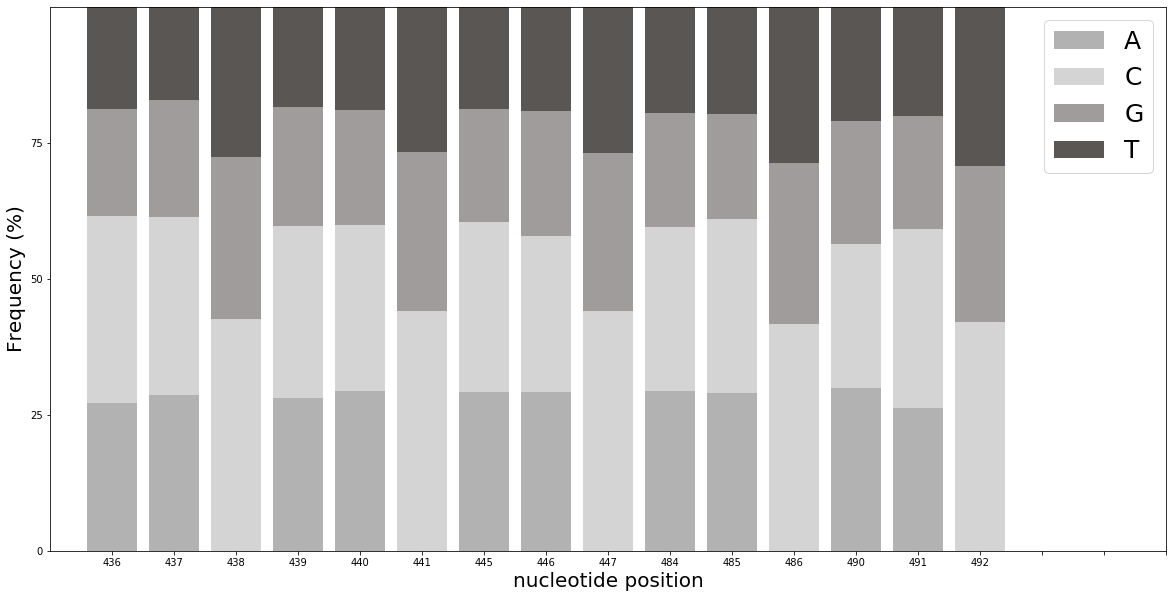

In [16]:
### Plot for Figure 3B

### calculate frequency for each base within unique DNA variants 

base_counter = np.zeros((4,15))      ### initialize counting table
bases = ["A","C", "G","T"]           ### look-up list for bases

### loop through DNA sequences in modified region
for oligo in oligo_lib.keys():
    for i in range(0,len(oligo)):
        for n in range(0,len(bases)):
            if oligo[i] == bases[n]:
                base_counter[n,i]+=1
                
### calculate observed base frequency in each position                
base_freq = base_counter/float(sum(base_counter[0:4,0]))*100  

### plot bars
plt.figure(figsize=(20,10))
p1 = plt.bar(np.arange(len(base_freq[0])),base_freq[0], color="#B2B2B2")
p2 = plt.bar(np.arange(len(base_freq[0])),base_freq[1], color ="#D5D4D4", bottom=base_freq[0])
p3 = plt.bar(np.arange(len(base_freq[0])),base_freq[2], color ="#9F9C9B", bottom=base_freq[0]+base_freq[1])
p4 = plt.bar(np.arange(len(base_freq[0])),base_freq[3], color ="#5A5654", bottom=base_freq[0]+base_freq[1]+base_freq[2])

### figure parameters 
axes = plt.gca()
axes.set_ylim([0,100])
axes.set_xlim([-1,12])
plt.legend((p1,p2,p3,p4),("A","C","G","T"), loc = 0, fancybox=True, fontsize=25)

### lables 
plt.yticks(np.arange(0,100,25))
plt.xticks(np.arange(0,18,1),[436,437,438,439,440,441,445,446,447,484,485,486, 490,491,492])
plt.ylabel('Frequency (%)', fontsize=20)
plt.xlabel('nucleotide position', fontsize=20)

### saving vectorized figure
plt.savefig("Figure_3B_ssODN.svg")   

### output
plt.show()

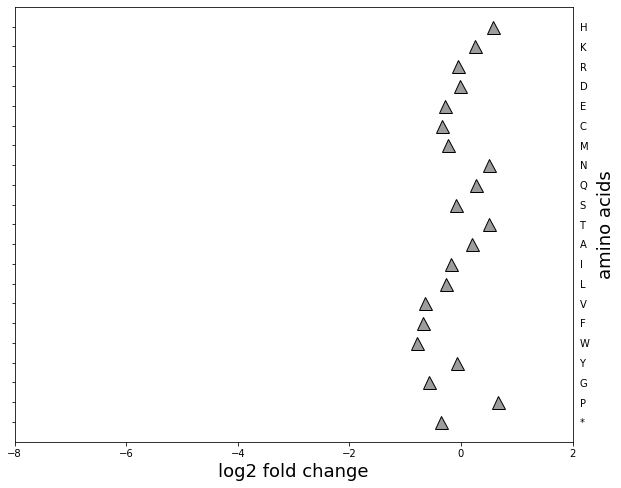

In [19]:
### Plot for Figure 3C


### list of amino acids 
amino_acids = np.array(("H","K","R","D","E","C","M","N","Q","S","T","A","I","L","V","F","W","Y","G","P","*"))
### list of number of codons for each amino acid when NNB is used as codon
codn_freq_NNB = np.array((2,1,4,2,1,2,1,2,1,5,3,3,2,4,3, 2,1,2,3,3,1))


peptide_counter_lib = {}                  ### initialize amino acid library
unique_counting_table = np.zeros((5,21))  ### initialize counting table

### loop through DNA library in modified position, translate and add to amino acid library
for oligo in oligo_lib:
    peptide = str(Seq(oligo, IUPAC.unambiguous_dna).translate())
    
    if peptide not in peptide_counter_lib:
        peptide_counter_lib[peptide] = 1
    elif peptide in peptide_lib:
        peptide_counter_lib[peptide] +=1 

### count amino acids in modified region 

for peptide in peptide_counter_lib.keys():
    for i in range(0,5):
        for n in range(0,21):
            if peptide[i] == amino_acids[n]:
                unique_counting_table[i,n] += peptide_counter_lib[peptide]

### calculate observed and expected frequency for each amino acid                
unique_observed_freq = np.sum(unique_counting_table, axis=0)/np.sum(unique_counting_table)
expected_freq = codn_freq_NNB/float(sum(codn_freq_NNB))


### figure parameters
plt.figure(figsize=(10,8))
plt.xlim(-8,2)
plt.ylim(-1,21)


### labels 
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.yticks(range(0,21),amino_acids[::-1])
plt.ylabel('amino acids', labelpad=-600, fontsize=18)
plt.xlabel("log2 fold change", fontsize=18)
plt.plot((np.log2(unique_observed_freq)-np.log2(expected_freq))[::-1],range(0,21),
         marker = '^', linestyle = '', markerfacecolor='#9D9D9C', markeredgecolor='k', markersize=13);


### save vectorized image 
plt.savefig("Figure_3C_ssODN.svg")

### Supplementary Figure 4

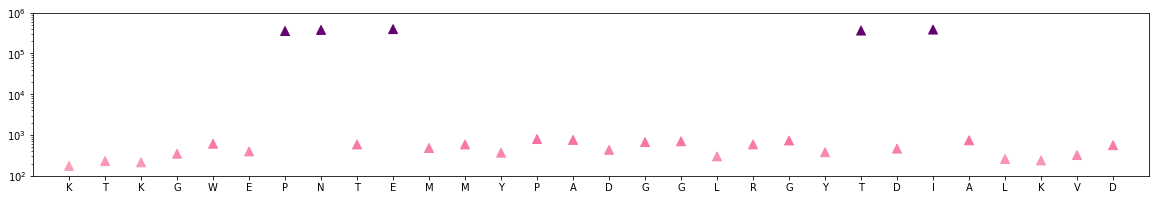

In [10]:
### Plot for Supplementary Figure 4  top


### generate x-label from wt DNA sequence
wt_seq = "AAGACCAAGGGTTGGGAGCCTAATACAGAGATGATGTATCCAGCAGATGGTGGTCTGAGGGGATACACTGATATTGCACTGAAAGTTGAT"

label_list = []
for i in str(Seq(wt_seq, IUPAC.unambiguous_dna).translate()):
    label_list.append(i)

counter_array = np.zeros(30) ### initialize counter

### loop through protein library and counts occurcane of none-wt amino acids in each position
for peptide in long_peptide_lib.keys():
    for i in range(0,30):
        if peptide[i] != label_list[i]:
            counter_array[i] += long_peptide_lib[peptide]

### figure parameters              
plt.figure(figsize=(20,3))
plt.yscale('log')
plt.ylim(100,1000000)
plt.xlim(-1,30)


plt.scatter(range(0,30),counter_array,c=np.log10(counter_array), vmin=0, vmax=6, marker="^", s=80, cmap="RdPu")

## lables
plt.xticks(range(0,30), label_list);

### saving vectorized figure
plt.savefig("Supplementary_Figure_4_1.svg")    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


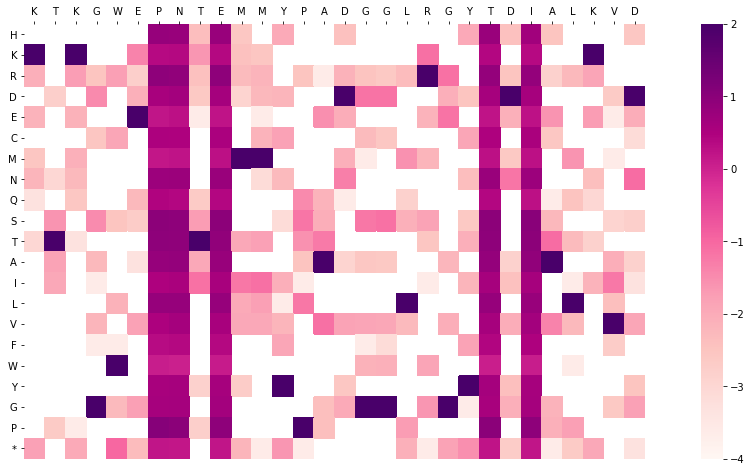

In [12]:
### Plot for Supplementary Figure 4 bottom:

### list of amino acids
amino_acids = np.array(("H","K","R","D","E","C","M","N","Q","S","T","A","I","L","V","F","W","Y","G","P","*"))
### initialize counting table 
long_counting_table = np.zeros((30,21))

### loop through protein library and count amino acids in each position 
for peptide in long_peptide_lib.keys():
    for i in range(0,30):
        for n in range(0,21):
            if peptide[i] == amino_acids[n]:
                long_counting_table[i,n] += long_peptide_lib[peptide]

                
                
### figure parameters                
plt.figure(figsize=(20,8))

### lables
ax = plt.axes()
ax.xaxis.set_ticks_position('top');




sns.heatmap(np.log10(long_counting_table/float(sum(long_peptide_lib.values()))*100).transpose(),
            vmin=-4,vmax=2, cmap="RdPu", xticklabels=label_list,yticklabels=amino_acids,
            cbar_kws={"orientation": "vertical"}, square =True );

plt.yticks(rotation=0);

### save vectorized figure
plt.savefig("Supplementary_Figure_4_2.svg")

### Supplementary Figure 5

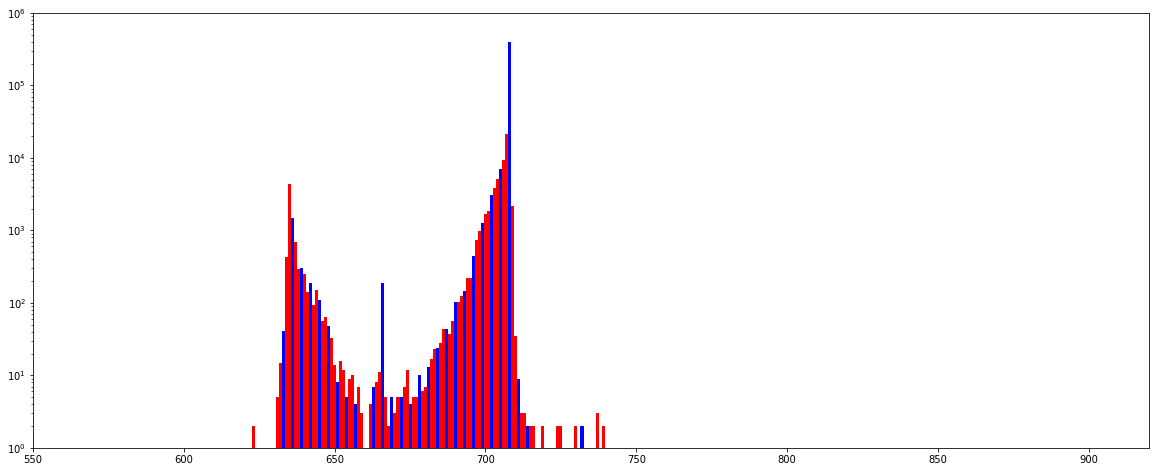

In [21]:
### Plot for Suplementary Figure 5 A left

### define figure parameters
plt.figure(figsize=(20,8))
plt.yscale('log')
plt.ylim(1,1000000)
plt.xlim(550,920)

### differenciate between in frame and out of frame, plot blue and red respectively
for key in length_dict.keys():
    if key % 3 == 0:
        plt.bar(key+618,length_dict[key],width=1,linewidth=0.2,color="blue");
    else:
        plt.bar(key+618,length_dict[key],width=1,linewidth=0.2,color="red");
        
### saving vectorized figure 
plt.savefig("Supplementary_Figure_5A.SVG")      

In [20]:
### Supplementary Figure 5 B

### count in-frame and out of frame variants

frame_counter = np.zeros(2)  ### initialize 

### loops through all lengths and checks if in frame or not and counts instances 
for length in length_dict.keys():
    if (length) % 3 == 0:
        frame_counter[0] += length_dict[length]
    else:
        frame_counter[1] += length_dict[length]

### calculate percent 
ratios = frame_counter/float(sum(frame_counter))*100     

### output 
print("in frame: %2.1f %% out of frame: %2.1f %%" % (ratios[0],ratios[1]))

in frame: 88.3 % out of frame: 11.7 %
